# Minions vertical motion simulations

- could simulate drop weight as well


---

## Equations of motion

<img src="float_displacement.png" alt="Drawing" align="right" style="width: 300px;"/>

Useful reference: P. Lherminier thesis (Annex 3, [link](https://tel.archives-ouvertes.fr/tel-00881646)):
which is strongly inspired from Voorhis (1971) (link).
We ignore rotational dynamics which is less relevant when the float is not equipped with propellers.

Central variables are:
- $z_f$ : float vertical position
- $z_w$ : water vertical position
- $z_r=z_w-z_f$: water vertical position with respect to the float position

Corresponding velocities are:
$w_f=\frac{dz_f}{dt}$, $w=\frac{dz_w}{dt}$, $w_r=w-w_f$

The dynamical equation ruling the float vertical displacement looks like:

$$
\begin{align*}
(1+a) \frac{d^2z_f}{dt^2}
+ c_d \frac{dz_f}{dt} = 
g \frac{\rho_w-\rho_f}{\rho_f} %\\
+ c_d w
+ (1+a) \frac{dw}{dt}
+  w_r \partial_z w,
\end{align*}
$$

where $a$ is the added mass coefficient, $c_d$ the drag coefficient, 
$\rho_f=m/V$ is the float density, $\rho_w$ is water density.

Note that in the simulations, we neglect water velocity non linear accelerative contributions.
Other assumptions made:

- the float follows horizontal motions exactly
- instantaneous thermal equilibrium

In [1]:
from copy import deepcopy

import xarray as xr
import pandas as pd
import numpy as np
import scipy.io as sio

import matplotlib.pyplot as plt

import gsw

import cognac.ufloat as fl

---

## Start by selecting a water stratification profile


In [2]:
def parse_minion_mat(mat_file):
    """ parser of Minion mat file """

    d = sio.loadmat(mat_file)
    # d['minion2'], d['minion3'] for trajectories

    ctd={}
    for v, i in zip(['rho', 'sigma0', 'z', 'temperature', 'salinity'],
                    range(5),
                   ):
        ctd[v] = d['profile'][0][0][i].squeeze()

    ctd['lon'] = -122
    ctd['lat'] = 37

    ctd['pressure'] = gsw.p_from_z(ctd['z'], ctd['lat'])

    return ctd

In [3]:
data_dir = '/Users/aponte/Current_projects/cognac/minions/'
mat_file = data_dir+'MinionData_for_Aurelien.mat'

ctd = parse_minion_mat(mat_file)
w = fl.waterp(**ctd)

#w.plot(type="matplotlib")
w.plot()

:NdLayout   [Variable]
   :Curve   [z]   (value)

In [4]:
# smooth vertical profile a bit
Ns = 10 # number of points for the rolling mean

df = pd.DataFrame(ctd)
dfs = (
    df
    .set_index("pressure")
    .rolling(Ns, center=True).mean()
    .bfill().ffill()
    .reset_index()
)
ws = fl.waterp(**{v: dfs[v].values for v in ["pressure", "temperature", "salinity"]}, lon=ctd["lon"], lat=ctd["lat"])

In [5]:
ws.plot()

:NdLayout   [Variable]
   :Curve   [z]   (value)

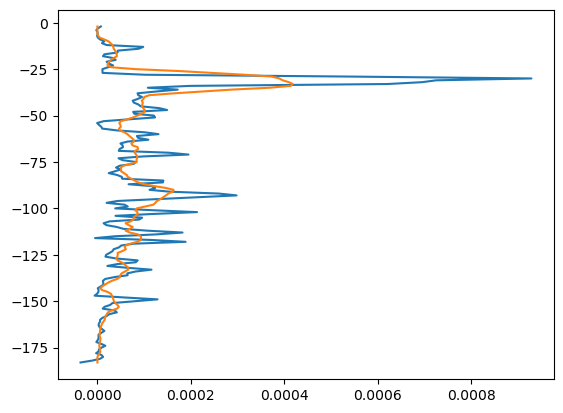

In [6]:
plt.plot(w.bg["N2"], w.bg["z"])
plt.plot(ws.bg["N2"], ws.bg["z"])

In [7]:
# use smoothed profile instead
w = ws

In [8]:
# test isopycnal estimation calculation

if False:

    z = np.arange(-100,-50)
    te = np.ones(z.size)*10
    #get_isopycnal_displacement(w, -50, 300, temperature=10)
    #eta = get_isopycnal_displacement(w, z, 300, dvdz=5/150, temperature=te)
    eta = get_isopycnal_displacement(w, z, 300, temperature=te, method="sorted")

    fig, ax = plt.subplots(1,1)
    #ax.plot(z+eta,z)
    ax.plot(w.bg.temperature,w.bg.z)
    ax.plot(te,z)
    ax.scatter(te,z-eta, s=20, c="k")
    #ax.set_xlim(-100,100)
    #ax.set_xlim(-100,100)

---

## instantiate float

The float is less compressible than water here and naturally stable.

In [9]:
#
f = fl.autonomous_float(model='minion')
print(f)

infer mass from volume with rho=1030 kg/m3, m = 2.621 kg
Float parameters: 
  L     = 0.40 m      - float length
  r     = 0.04 m      - float radius
  m     = 2.62 kg     - float mass
  V     = 2.54e+03 cm^3   - float volume
  rho_cte = m/V = 1.03e+09 kg.cm^3   - float baseline density
  gamma = 3.51e-06 /dbar  - mechanical compressibility
  gamma x V = 8.93e-03 cm^3/dbar  - normalized compressibility
  alpha = 1.20e-05 /degC  - thermal compressibility
  alpha x V = 3.05e-02 cm^3/degC  - normalized thermal compressibility
  temp0 = 0.00e+00  degC  - reference temperature
  a = 1.00e+00  (no dimension)  - float added mass
  drag_model = quadratic  0
  drag_c1 = 1.00e+00  (no dimension)  - float drag parameter



In [10]:
# adjust mass to target one depth
z_equilibrium = -40.
_w = w.at(z=z_equilibrium, extra=True)
rho_w, p, temp, N2 = _w["rho"], _w["pressure"], _w["temperature"], _w["N2"]
f.adjust_m(p,temp,rho_w, offset=0.)

f0 = deepcopy(f)

-11.3 g  were added to the float in order to be at equilibrium at 40 dbar 



<Axes: xlabel='[kg/m^3]', ylabel='z [m]'>

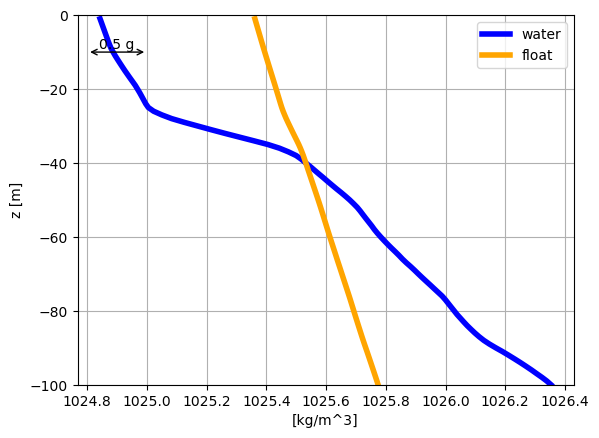

In [11]:
z=np.arange(-100.,0.,1.)
fl.plot_float_density(z, f, w) #, v_air=10*fl.cm3)

---
### settling experiment

Note that one could add the effect of a drop weight as well as that of air

In [12]:
T = 2*3600.
%time f.time_step(w,T=T, dt_step=5., dt_log=10., z=-5., w=0., Lv=f.L)

Start time stepping for 120 min ...
... time stepping done
CPU times: user 24.9 s, sys: 431 ms, total: 25.3 s
Wall time: 32.5 s


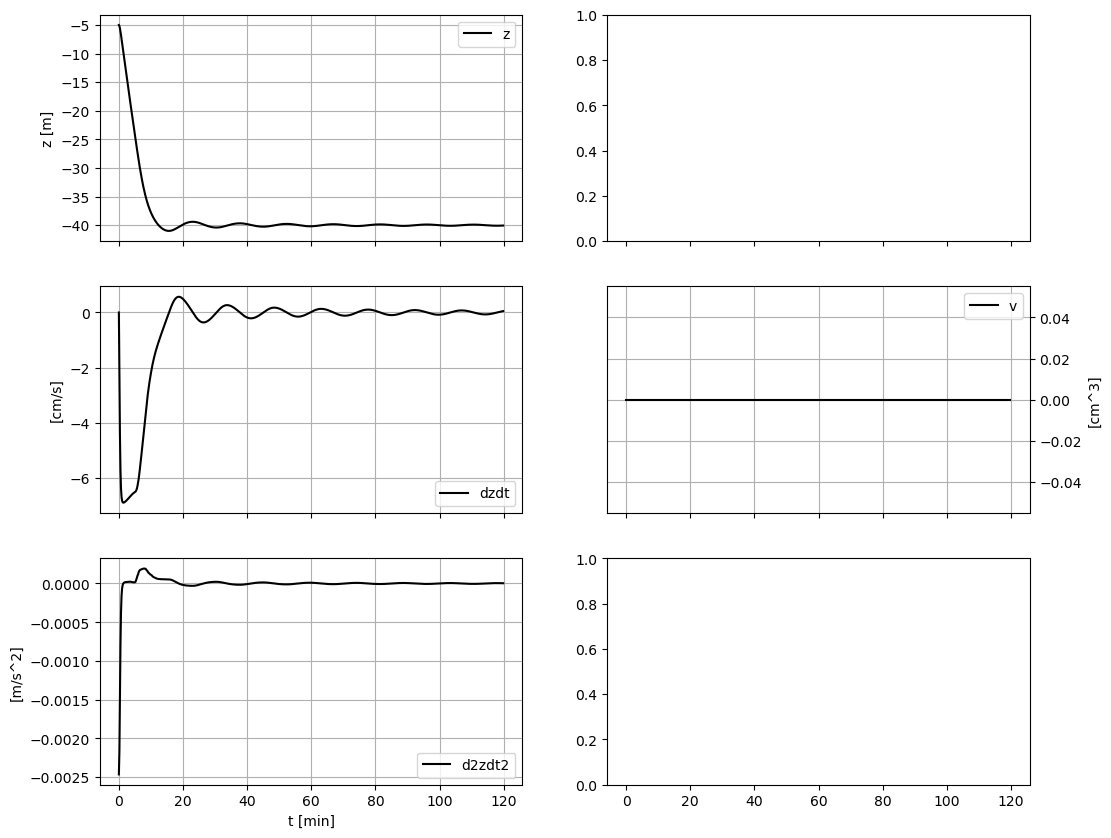

In [13]:
f.plot_logs()

Text(0.5, 1.0, 'float trajectory during settling')

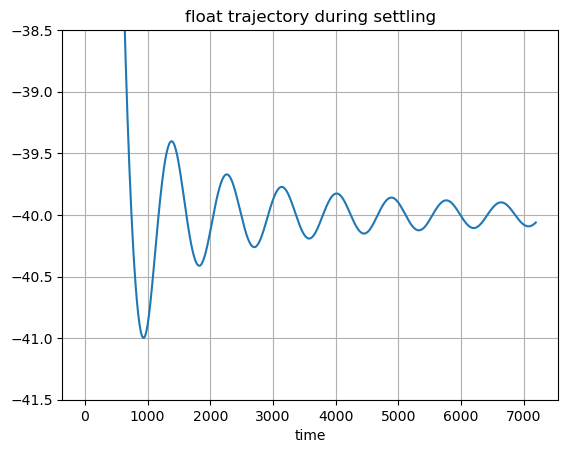

In [14]:
# zoom
ax = plt.subplot(111)
f.log['state']['z'].plot(ylim=(-41.5,-38.5), ax=ax)
ax.grid()
ax.set_title("float trajectory during settling")

In [15]:
# inspect dynamics
#f.log["dynamics"].df.set_index("time").plot()

One should try to adjust:

- the amplitude of oscillations by playing on drag.
- the frequency is related to stratification and potentially compressibilities.

---

## response to moving isopycnals

### theoretical transfer functions


(see overleaf for details)

The transfer function $H_f^r$ between float displacements and relative water displacements is the one that is the most easily estimated from observations:

$
\begin{align}
\hat{z}_r &= \hat{z}_w - \hat{z}_f = \mathcal{H}_f^r(\omega) \hat{z}_f, \\
\mathcal{H}_f^r(\omega) &= 
\frac{\mathcal{H}_w^r(\omega)}{1-\mathcal{H}_w^r(\omega)} 
= \frac{\mathcal{H}_w^r(\omega)}{\mathcal{H}_w^f(\omega)}
, \\
&= \frac{M^2 - N^2 + L^2}{N^2 - L^2 - (1+a)\omega^2 - i \omega c_d}, \\
&= \frac{\gamma_w - \gamma_f + \alpha_f\Gamma_w}{N^2 - L^2 - (1+a)\omega^2 - i \omega c_d},
\end{align}
$

#### at 40 m depth (equilibrium depth)

In [18]:
# base case: depth dependance + at a single depth

f = deepcopy(f0)
H = f.get_transfer_functions(w, 0.01, (-4, -2), cd_kwargs=dict(Lv=f.L))

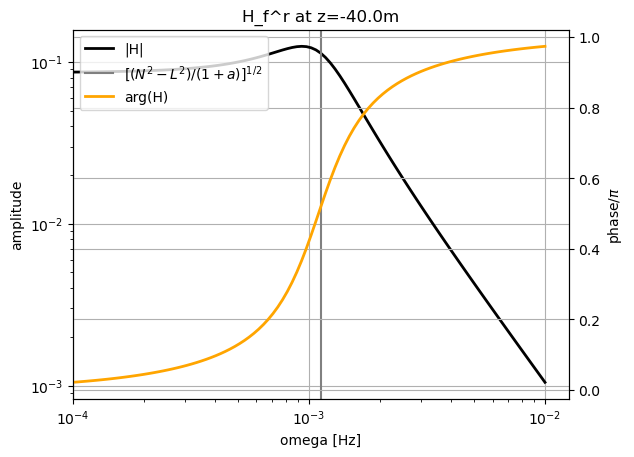

In [19]:
Heq = H.sel(z=z_equilibrium, method="nearest")

H_label = "H_f^r"
da = Heq[H_label]
#dab = Heq["H_w^r"]

fig, ax = plt.subplots(1,1)

h0 = ax.plot(da.omega, np.abs(da), 'k', lw=2, label="|H|")
#h0b = ax.plot(da.omega, np.abs(dab), 'b', lw=2, label="|H|")
h1 = ax.axvline(np.sqrt((Heq.N2)/(1+f.a))/2/np.pi, color="0.5", ls="-", label=r"$[(N^2-L^2)/(1+a)]^{1/2}$")
#ax.axvline(np.sqrt((Heq.N2-Heq.L2)/(1+f.a))/2/np.pi, color="0.5", ls="--")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title(f"{H_label} at z={z_equilibrium:.1f}m")
ax.set_xlabel("omega [Hz]")
ax.set_ylabel("amplitude")

axp = ax.twinx()
angles = np.unwrap(np.angle(da))/np.pi
h2 = axp.plot(da.omega, angles, 'orange', lw=2, label="arg(H)")
ax.grid()
axp.grid()
axp.set_ylabel(r"phase/$\pi$")

ax.set_xlim(1e-4, None)

axp.legend(handles=[h0[0], h1, h2[0]], loc=2)

The frequency of the peak of the resonance is controlled by the vertical stratification and added mass (if not small compared to 1).

The amplitude of the resonance is weak and dependent on the drag (loosely constrained parameter)

In [17]:
#_w = w.at(z=H.z.values, extra=True)
#(-9.81*_w.drho_dz/_w.rho).plot(y="z")
#H.N2.plot(y="z")
#(-9.81*_w.drho_dz/_w.rho - H.N2).plot(y="z")

#(2e-4*w.bg["adiabatic_lapse_rate"]).plot()

Text(0.5, 1.0, 'mean(M2-N2+L2)=8.36e-06')

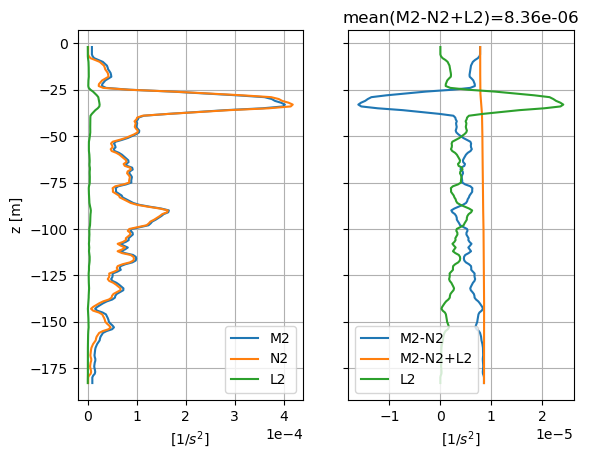

In [24]:
fig, axes = plt.subplots(1,2, sharey=True)

ax = axes[0]
ax.plot(H.M2, H.z, label="M2")
ax.plot(H.N2, H.z, label="N2")
ax.plot(H.L2, H.z, label="L2")
ax.legend()
ax.ticklabel_format(axis='x', scilimits=[-3, 3])
ax.grid()
ax.set_ylabel("z [m]")
ax.set_xlabel(r"$[1/s^2]$")

ax = axes[1]
ax.plot(H.M2-H.N2, H.z, label="M2-N2")
ax.plot(H.M2-H.N2+H.L2, H.z, label="M2-N2+L2")
ax.plot(H.L2, H.z, label="L2")
#ax.plot(f, H.z, label="L2")
ax.legend(loc=3)
ax.grid()
ax.set_xlabel(r"$[1/s^2]$")
_mean = (H.M2-H.N2+H.L2).mean()
ax.set_title(f"mean(M2-N2+L2)={_mean:.2e}")

In [25]:
# print various water properties:
_w = w.at(z=H.z.values, extra=True).mean()

print(f"float compressibiliy γ_f={f.gamma:.2e}")
print(f"water compressibiliy γ_w={_w.kappa:.2e}")
print(f"g x (γ_w - γ_f)= {9.81*(_w.kappa-f.gamma):.2e}")

float compressibiliy γ_f=3.51e-06
water compressibiliy γ_w=4.36e-06
g x (γ_w - γ_f)= 8.35e-06


#### over full water column

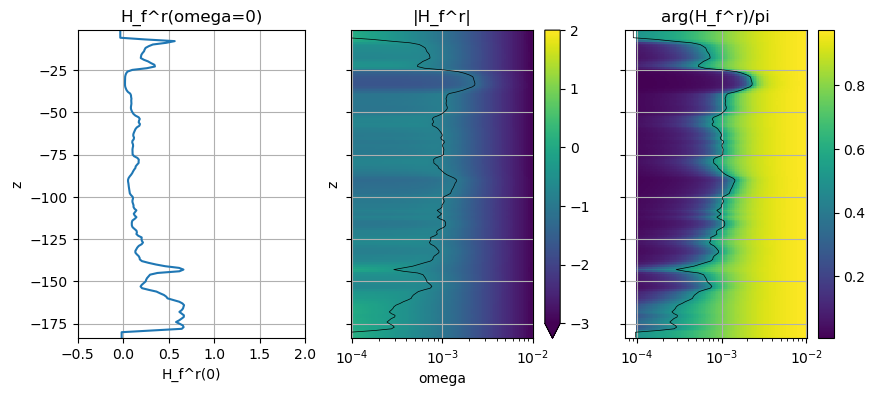

In [26]:
H_label = "H_f^r"
da = H[H_label]
omega_res = np.sqrt((H.N2)/(1+f.a))/2/np.pi

fig, axes = plt.subplots(1, 3, sharey=True, figsize=(10,4))

ax = axes[0]
np.real(da.sel(omega=0, method="nearest")).rename("H_f^r(0)").plot(ax=ax, y="z")
#ax.plot(omega_res, omega_res.z, color="k", lw=.5)
#ax.set_xscale("log")
ax.set_xlim(-.5,2)
ax.grid()
ax.set_title(f"{H_label}(omega=0)")

ax = axes[1]
np.log10(np.abs(da)).rename(f"").plot(ax=ax, x="omega", vmin=-3, vmax=2)
ax.plot(omega_res, omega_res.z, color="k", lw=.5)
ax.set_xscale("log")
ax.set_title(f"|{H_label}|")
ax.grid()

ax = axes[2]
h = ax.pcolormesh(da.omega, da.z, np.angle(da)/np.pi)
fig.colorbar(h)
ax.plot(omega_res, omega_res.z, color="k", lw=.5)
ax.set_xscale("log")
ax.set_title(f"arg({H_label})/pi")
ax.grid()


At low frequencies and between 25m and 125m depth, the stratification is sufficiently strong such that the float mostly follows isopycnals ($H_r^w \sim 0$).

A resonance is observed between $0.1$mHz and $1$ mHz.

At larger frequencies, the float follows isopycnals again.

#### sensitivities of transfer function to parameters

Should do:

- drag coefficient

In [22]:
# ... to be done

### illustration of the response to moving isopycnals

In [21]:
# utils
def plot_trajectory(f, eta, ylim_top=(-43,-37), ylim_bot=None):
    """ quick helper method """
    
    if ylim_bot is None:
        ylim_bot=-ylim_top[1], -ylim_top[0]

    df = f.log['state'].df
    df['time [minutes]'] = df.time/60.
    df = df.set_index('time [minutes]')

    df['eta'] = eta(df.time)
    df['detadt'] = df.eta.diff()/df.time.diff()
    
    #ax = plt.subplot(111)
    fig, axes = plt.subplots(2, 1, sharex=True)

    ax = axes[0]
    df['z'].plot(ax=ax, label="z_f")
    (df['eta']-40).plot(ax=ax, label="z_w")
    ax.set_ylim(ylim_top)
    ax.legend()
    ax.grid()
    
    ax = axes[1]
    (df['eta'] - df['z']).plot(ax=ax, label="z_w - z_f")
    ax.set_ylim(ylim_bot)
    ax.legend()
    ax.grid()

#### low frequency response

In [22]:
omega_resonance = np.sqrt((Heq.M2)/(1+f.a))/2/np.pi
print(f"Resonance occurs at omega={omega_resonance:.2e}Hz, T = {1/omega_resonance/60:.1f} min")

Resonance occurs at omega=1.15e-03Hz, T = 14.5 min


In [28]:
# isopycnal displacement
amplitude = 2. # m
period = 60 # min
eta = lambda t: amplitude*np.sin(2.*np.pi/(60.*period)*t)

In [29]:
# simulation
f = deepcopy(f0)

#z0 = -5 # from surface, includes initial dive
z0 = z_equilibrium+eta(0) # at equilibrium depth, excludes initial dive

#w0 = 0 # from rest, will kick oscillations
w.update_eta(eta, t=0.) # in order to have isopycnal velocities and initialize the flowat velocity
w0 = w.detadt # initial velocity match isopycnal ones, limits transients

f.time_step(w, T=T, dt_step=5., dt_store=10., z=z0, w=w0, eta=eta)
f_slow, eta_slow = f, eta # store

Start time stepping for 120 min ...
... time stepping done


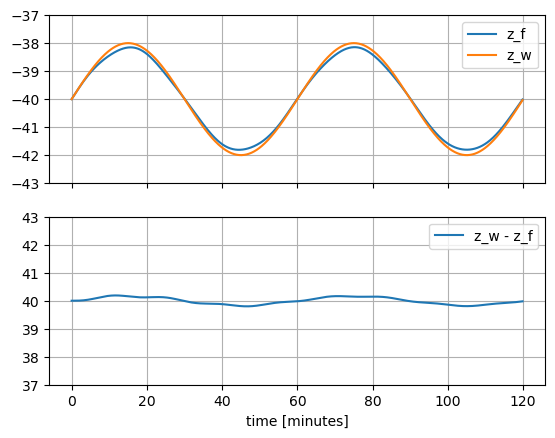

In [30]:
plot_trajectory(f_slow, eta_slow)

The float follows isopycnals up to a 10% threshold which corresponds to the value of the transfer function at low frequencies:

$
\begin{align}
z_w - z_f = 0.1 z_f, \\
z_w = 1.1 z_f.
\end{align}
$


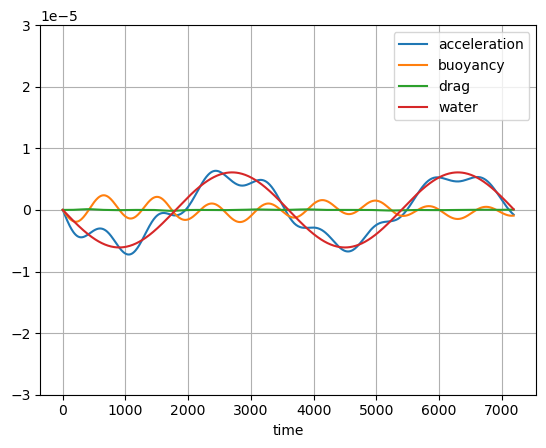

In [33]:
ax = f.log["dynamics"].df.set_index("time").plot()
ax.set_ylim(-3e-5, 3e-5)
ax.grid()

The vertical acceleration of water (associated pressure forces in fact) are dominant for the acceleration of the float

#### near resonant response

In [49]:
# isopycnal displacement
amplitude = 2. # m
period = 15. # min
eta = lambda t: amplitude*np.sin(2.*np.pi/(60.*period)*t)

In [50]:
# simulate
f = deepcopy(f0)

#z0 = -5 # from surface, includes initial dive
z0 = z_equilibrium+eta(0) # at equilibrium depth, excludes initial dive

#w0 = 0 # from rest, will kick oscillations
w.update_eta(eta, t=0.) # in order to have isopycnal velocities and initialize the flowat velocity
w0 = w.detadt # initial velocity match isopycnal ones, limits transients

f.time_step(w, T=T, dt_step=5., dt_store=10., z=z0, w=w0, eta=eta)
f_res, eta_res = f, eta # store

Start time stepping for 120 min ...
... time stepping done


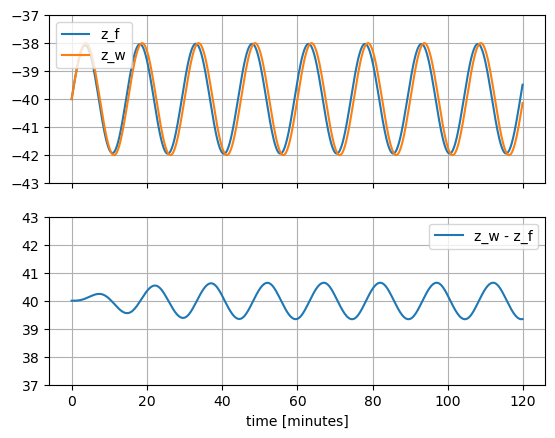

In [51]:
plot_trajectory(f_res, eta_res)

The resonant response is not nearly as high as that predicted theoretically.

Leads for explanation:
    
- mismatch between drag in the simulation and in the tranfer function
- ?

In [52]:
# inspect dynamics
#ax = f.log["dynamics"].df.set_index("time").plot()
#ax.set_ylim(-1e-3, 1e-3)
#ax.grid()

#### high frequency response

In [53]:
# isopycnal displacement
amplitude = 2. # m
period = 5 # min
eta = lambda t: amplitude*np.sin(2.*np.pi/(60.*period)*t)

In [59]:
# simulate
f = deepcopy(f0)

#z0 = -5 # from surface, includes initial dive
z0 = z_equilibrium+eta(0) # at equilibrium depth, excludes initial dive

#w0 = 0 # from rest, will kick oscillations
w.update_eta(eta, t=0.) # in order to have isopycnal velocities and initialize the flowat velocity
w0 = w.detadt # initial velocity match isopycnal ones, limits transients

f.time_step(w, T=T/2, dt_step=5., dt_store=10., z=z0, w=w0, eta=eta)
f_high, eta_high = f, eta # store

Start time stepping for 60 min ...
... time stepping done


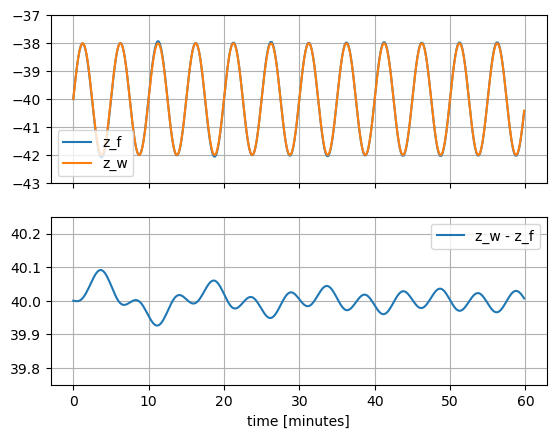

In [60]:
plot_trajectory(f_high, eta_high, ylim_bot=(39.75,40.25))

The float follows closely isopycnals, $z_r - z_f$ and z_f (z_w) are out of phase.
Matches theoretical prediction.

In [61]:
#ax = f.log["dynamics"].df.set_index("time").plot()
#ax.set_ylim(-1e-3, 1e-3)
#ax.grid()

---
### response to red noise + full interpretation of synthetic deployment

Build random isopycnal fluctuations and inspect float response

In [81]:
def get_eta_rednoise(amplitude, T, dt=1., T_cutoff=3600, shape="gaussian"):
    import scipy.fft as fft

    t = np.arange(0, T, dt)  # s
    omega = 2*np.pi*fft.fftfreq(t.size, dt)  # rad/s
    #np.max(omega), 1/2/dt # 5

    noise_hat = fft.fft(np.random.randn(t.size))
    if shape=="gaussian":
        eta_hat = noise_hat*np.exp(-(omega*T_cutoff)**2) # gaussian decorr
    elif shape=="2":
        # exp decorr
        eta_hat = noise_hat/np.sqrt((1+np.abs(omega*T_cutoff)**2))
    elif shape=="4":
        # acceleration is white noise
        eta_hat = noise_hat/np.sqrt((1+np.abs(omega*T_cutoff)**4))
    elif shape=="6":
        # acceleration is integrable
        eta_hat = noise_hat/np.sqrt((1+np.abs(omega*T_cutoff)**6))
    eta = fft.ifft(eta_hat).real
    eta = eta/np.std(eta) * amplitude
    eta = eta - np.mean(eta)
    #deta_dt = np.diff(eta)/dt
    df = pd.DataFrame(
        dict(eta=eta, time=t),
    )
    df["deta/dt"] = df["eta"].diff()/dt
    df["d2eta/dt2"] = df["deta/dt"].diff()/dt
    
    # isopycnal displacement
    eta_fun = lambda _t: np.interp(_t, t, eta)
    
    return t, df, eta_fun

def get_water_z(z, time, w, eta):
    """ get water properties at a level z"""
    D = []
    for t in time:
        w.update_eta(eta, t=t)
        d = w.at(z)
        d["time"] = t
        D.append(d)
    df = pd.DataFrame(D)
    df["time"] = df["time"]/60 # to minutes
    return df

### generate isopycnal displacement time series and inspect

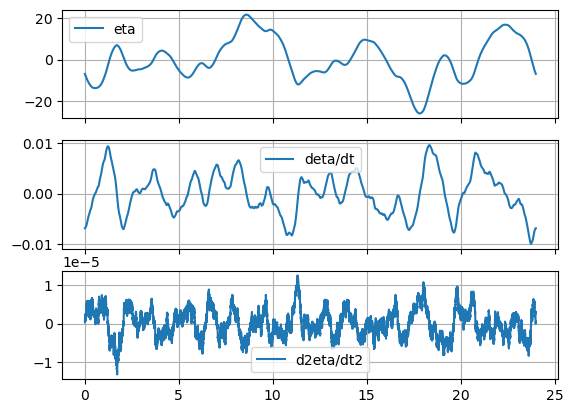

In [87]:
T_rn = T*12
t_rn, df_rn, eta = get_eta_rednoise(10, T_rn, dt=1., T_cutoff=3600/2, shape="6")

_df = df_rn.set_index("time")

fig, axes = plt.subplots(3,1, sharex=True)
for v, ax in zip(["eta", "deta/dt", "d2eta/dt2"], axes):
    ax.plot(_df.index/60/60, _df[v], label=v)
    ax.legend()
    ax.grid()

In [88]:
# simulate
f = deepcopy(f0)

z_ini = z_equilibrium

#z0 = -5 # from surface, includes initial dive
z0 = z_equilibrium+eta(0) # at equilibrium depth + , excludes initial dive

#w0 = 0 # from rest, will kick oscillations
w.update_eta(eta, t=0.) # in order to have isopycnal velocities and initialize the flowat velocity
w0 = w.detadt # initial velocity match isopycnal ones, limits transients

%time f.time_step(w, T=T_rn, dt_step=5., dt_store=10., z=z0, w=w0, eta=eta)
f_rnoise, eta_rnoise = f, eta

Start time stepping for 1440 min ...
... time stepping done
CPU times: user 4min 38s, sys: 3.58 s, total: 4min 41s
Wall time: 4min 59s


In [89]:
# massage a bit dataframes

dfs = f.log["state"].df 
dfw = f.log["water"].df 

z_mean = dfs["z"].mean()
z_mean

%time w_at_mean = get_water_z(z_mean, dfw["time"], w, eta)

dfs["time [minutes]"] = dfs["time"]/60
dfw["time [minutes]"] = dfw["time"]/60
#w_at_mean["time [minutes]"] = w_at_mean["time"]

CPU times: user 2min 24s, sys: 1.98 s, total: 2min 26s
Wall time: 2min 43s


In [97]:
def plot_float_tseries(dfs, dfw, dfw_mean, z_mean):
    
    dfs = dfs.set_index("time [minutes]")
    dfw = dfw.set_index("time [minutes]")
    dfw_mean = dfw_mean.set_index("time")

    fig, axes = plt.subplots(3, 1, sharex=True)

    # z
    ax = axes[0]
    ax.plot(dfs.index, dfs.z, label="z_f")
    ax.plot(dfw.index, z_mean + dfw.eta, label="z_mean + eta")
    ax.grid()
    ax.legend()
    ax.set_ylabel("[m]")


    # T
    ax = axes[1]
    ax.plot(dfw.index, dfw.temperature, label="T(z_f)")
    if dfw_mean is not None:
        ax.plot(dfw_mean.index, dfw_mean.temperature, label="T(z_mean)")
    ax.grid()
    ax.legend()
    ax.set_ylabel("[degC]")

    # velocities
    ax = axes[2]
    w
    ax.plot(dfs.index, dfs.w, label="dz_f/dt")
    ax.plot(dfw.index, dfw.detadt, label="dz_w/dt")
    ax.grid()
    ax.legend()
    ax.set_ylim(-.03,.03)
    ax.set_ylabel("[m/s]")

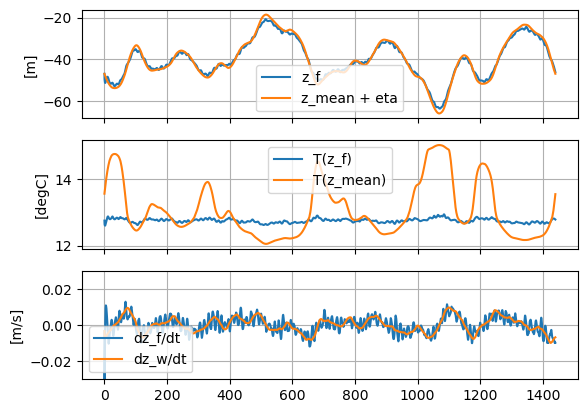

In [98]:
plot_float_tseries(dfs, dfw, w_at_mean, z_mean)

**To add :**

- [X] Show what observations would show: depth + temperature
- [ ] Remind formula for isopycnal displacement (or relative ) estimation and evaluate performance
- Compare to variables that are not accessible and would need to be infered: isopycnal displacement ?

- Compute spectra of observable (or derivable) quantities.
- Can we reconstruct the transfer function?